In [6]:
import os
import sys
# print(sys.path)
import subprocess
import shutil
import pandas as pd
import numpy as np
import calendar
import traceback
import json
from pyutils import *
from pdutils import *
from pdpltutils import *
from gputils import *
from iputils import *
import xmltodict
import re
import itertools

from kmlmaker import KMLMaker as kmlm
from kmlproc import KMLCombiner
from kmlproc import TermexPingCombiner

In [2]:
if sys.platform == "linux":
    DATADIR="/home/jblake1/Downloads/Network_Measurements"
else:
    DATADIR="P:\\My Drive\\CMU-LEL\\Mill19\\Coverage and Performance"
    EXPDIR=os.path.join(*[DATADIR,"2024-10-24-PTC-Testing","LEL-UE1"])

DIRCHECKLIST=[DATADIR,EXPDIR]
for DIR in DIRCHECKLIST:
    print(f"{DIR} exists") if os.path.isdir(DIR) else print(f"{DIR} does not exist")

P:\My Drive\CMU-LEL\Mill19\Coverage and Performance exists
P:\My Drive\CMU-LEL\Mill19\Coverage and Performance\2024-10-24-PTC-Testing\LEL-UE1 exists


### KML File Processing

In [ ]:

ffnlst = walkDir(EXPDIR)
# print(ffnlst)
pngfiles = [fn for fn in ffnlst if ".png" in fn]
kmlfiles =  [fn for fn in ffnlst if ".kml" in fn ]
txtfiles =  [fn for fn in ffnlst if ".txt" in fn ]

print(f"pngfiles={len(pngfiles)} kmlfiles={len(kmlfiles)} txtfiles={len(txtfiles)}")
rxlevfiles = [fn for fn in kmlfiles if "rxlev.kml" in fn]
print(rxlevfiles)

In [ ]:
# EXPDIR=os.path.join(*[DATADIR,"2024-10-10-Mill19-Testing","LEL-UE1"])
def runUE(filename=None,filtervalue="Living_Edge_Lab"):
    kc = kmlc()
    # kc.setFiles(rxlevfiles)
    kc.findFiles(EXPDIR)
    kc.combine(ftype='merge')
    kc.inflate()
    kc.labelsOn()
    kc.filter(filterin = True, filtervalue=filtervalue)
    kc.writeKMLFile(filename=filename)
    return kc

filename = 'MadeOutput' + "_".join(EXPDIR.split("\\")[-2:]) + '.kml'
print(filename)
kc = runUE(filename=filename,filtervalue="314737")

### Termux Ping Logs (parse and add to KML)

In [ ]:
pingtxtfiles = [fn for fn in txtfiles if "ping" in fn]
# print(pingtxtfiles)

In [ ]:
''' Combine Ping Files '''
tdft = pd.DataFrame(pingtxtfiles,columns=['FFN'])
tdft['FILEDATA'] = tdft.FFN.map(kc.readFile)
columns = ["PINGTIMES"]
tdfx = pd.DataFrame(columns = columns)
for fdata in list(tdft.FILEDATA):
    sdata = [dline.strip("\n") for dline in fdata[1:]]
    tdfy = pd.DataFrame(sdata,columns = columns)
    tdfx = pd.concat([tdfx, tdfy],axis=0)

dumpdf(tdfx)


In [ ]:
print(tdfx.PINGTIMES.iloc[0])

In [ ]:
def parseTMXPingLine(row):
    text = row.PINGTIMES
    matchts = r"\[(.*?)\].*"
    matchpt = r".*time=(.*?) ms.*"
    return [float(re.sub(matchts, r'\1', text)),float(re.sub(matchpt, r'\1', text))]
tdfx[['LTIMESTAMP','PINGTIME']] = tdfx.apply(parseTMXPingLine,axis=1,result_type='expand')
# dumpdf(tdfx)
# Convert to datetime, assuming the timestamps are in seconds
tdfx['TIMESTAMP'] = pd.to_datetime(tdfx['LTIMESTAMP'], unit='s')
# Set the timezone (e.g., to 'US/Eastern')
tdfx['TIMESTAMP'] = tdfx['TIMESTAMP'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
tdfx = tdfx[['TIMESTAMP','PINGTIME']]
tdfx['PINGTS'] = tdfx.TIMESTAMP # Save for reference later

# tdfx = tdfx[tdfx.PINGTIME < 1000]

dumpdf(tdfx)

In [14]:
def histplot(dfin,title='Unknown Title',ax=None,filename='tmp.png', 
    figsize=(5,5), xlabel='',ylabel='',tabon=True, saveon=False,legend=False,
    bins=10, alpha=0.5, fontsize = 15, yticks = True,
    tabfontsize = 30, tabsizex = 1,tabsizey=2,**kwargs):
    font = {'size':fontsize}
    matplotlib.rc('font',**font)
    df = pd.DataFrame(dfin) # in case actually a series
    ''' Parameters '''
    if ax is None:
        ax = plt.figure(figsize=figsize).add_subplot(111)
    ''' Plot '''
    ax = df.plot.hist(bins=bins,alpha=alpha,title=title,figsize=figsize,ax=ax,legend=legend,**kwargs)
    ax.set_xlabel(xlabel)
    if not yticks: ax.set_yticklabels([])
    # print(tabon)
    if tabon:
        tabcolWidths = [0.2]
        tab = table(ax,np.round(df.describe(),2),loc='upper right',colWidths=tabcolWidths)
        tab.set_fontsize(tabfontsize)
        tab.scale(tabsizex,tabsizey)
    if saveon:
        print("Saving %s" % filename)
        savePlot(ax,filename)
    return ax

# title="Termux Ping Logs"
# ax=None
# histplot(tdfx[tdfx.PINGTIME < 100].PINGTIME,ax=ax,tabon=False, title=title,saveon=False,bins=100)

In [ ]:
kc = kmlc()
kc.findFiles(EXPDIR)
kc.combine()
# _=kc.filter(filterin = True, filtervalue="314737")
_=kc.filter(filterin = True, filtername="PHONE STATE", filtervalue="D")
dumpdf(kc.rxlevdf)

In [ ]:
tdfy = pd.DataFrame(kc.kresult['kml']['Folder']['Placemark'])

def getDataKeyValue(key,extralst):
    for edata in extralst['Data']:
        if edata['@name'] == key:
            return edata['value']
    return None

tdfy['TIMESTAMP'] = tdfy.ExtendedData.map(lambda xx: getDataKeyValue('TIME',xx))
tdfy = to_ts(tdfy,format = '%Y.%m.%d_%H.%M.%S',origtz = "US/Eastern", newtz="US/Eastern")

In [ ]:
dumpdf(tdfy)
dumpdf(tdfx)

In [ ]:
tdfz = pd.merge_asof( tdfy.copy().sort_values('TIMESTAMP'),tdfx.copy().sort_values('TIMESTAMP'), on='TIMESTAMP',direction='nearest').copy()

In [ ]:
dumpdf(tdfz)

In [ ]:
# tdfz.iloc[98:100].ExtendedData.map(print)

key="PINGTIME"
tdfz = tdfz.apply(kc.addDataKeyValue,axis=1, inkey=key)

# tdfz.iloc[98:100].ExtendedData.map(print)

In [ ]:
''' Get rid of datapoints where last ping was too time distant from network measurement '''
tdfz['DELTATS'] = tdfz.TIMESTAMP-tdfz.PINGTS
tdfz = tdfz[tdfz.DELTATS < pd.Timedelta('20 seconds')]
dumpdf(tdfz)

In [ ]:
newdatalst = list(tdfz.ExtendedData.map(lambda xx: xx['Data']))
# print(newdatalst)
_=kc.replaceExtendedData(newdatalst)

In [ ]:
_=kc.inflate()
_=kc.filter(filterin = True, filtername="PHONE STATE", filtervalue="D")

In [ ]:
kc.writeKMLFile(filename=filename)

In [ ]:
def getEDataFields(fdf):
    retdf = fdf.copy()
    edatadf = fdf.ExtendedData.map(lambda xx: xx['Data'])
    fielddf = edatadf.map(lambda xx: [subdict['@name'] for subdict in xx])
    flst = list(set(itertools.chain.from_iterable(list(fielddf))))
    for fld in flst:
       retdf[fld] = retdf.ExtendedData.map(lambda xx: getDataKeyValue(fld,xx))
    return retdf


def getStyleFields(fdf):
    retdf = fdf.copy()
    retdf['LabelScale'] = fdf.Style.map(lambda xx: xx['LabelStyle']['scale'])
    retdf['IconScale'] = fdf.Style.map(lambda xx: xx['IconStyle']['scale'])
    retdf['IconColor'] = fdf.Style.map(lambda xx: xx['IconStyle']['color'])
    retdf['Icon'] = fdf.Style.map(lambda xx: xx['IconStyle']['Icon']['href'])
    return retdf

def getCoordinates(fdf):
    retdf = fdf.copy()
    retdf[['Latitude','Longitude','Elevation']] = retdf.apply(lambda xx: xx.Point['coordinates'].split(","),  axis=1, result_type="expand")
    return retdf

def kmlToDF(kmldict,filename=None):
    fdf = pd.DataFrame(kmldict['kml']['Folder']['Placemark'])
    fdf = getEDataFields(fdf)
    fdf = getStyleFields(fdf)
    fdf = getStyleFields(fdf)
    fdf = getCoordinates(fdf)
    fdf = drp_lst(fdf,['ExtendedData','Style','Point'])
    if filename is not None:
        pass
    return fdf

tdfy = kmlToDF(kc.kresult)
dumpdf(tdfy)

In [ ]:
kc.kmlToDF(filename="tmp-jupyter.csv")

TypeError: no numeric data to plot

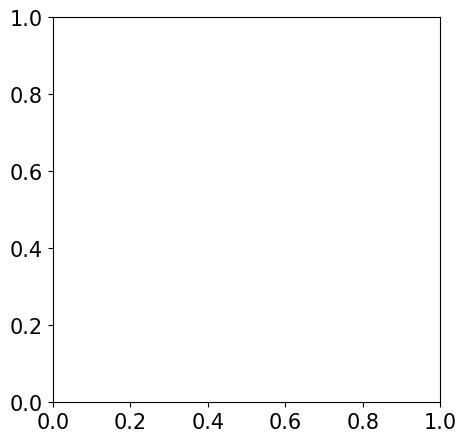

In [7]:
''' End to End Using kmlc.py '''
tpc = TermexPingCombiner()
tpc.findFiles(EXPDIR)
tpc.combine()

kc = KMLCombiner()
# kc.setFiles(rxlevfiles)
kc.findFiles(EXPDIR)
kc.combine(ftype='merge')
kc.addTermuxPing(tpc.getResult())
kc.inflate()
kc.labelsOn()
kc.filter(filterin = True, filtervalue="314737")
kc.filter(filterin = True, filtername="PHONE STATE", filtervalue="D")
kc.genHistogram()
kc.writeKMLFile(filename=filename)

Saving PINGTIMES_2024-10-24-PTC-Testing-LEL-UE1.png


<Axes: title={'center': 'PINGTIMES_2024-10-24-PTC-Testing-LEL-UE1'}, ylabel='Frequency'>

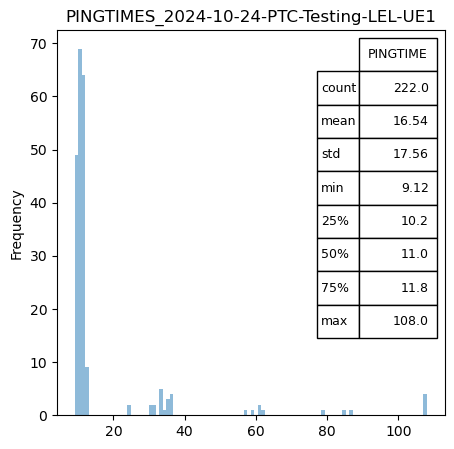

In [27]:
title="PINGTIMES_" + "-".join(EXPDIR.split("\\")[-2:])
filename=title+".png"
tdfx = kc.kmlToDF()

ax=None
histplot(tdfx[tdfx.PINGTIME < 200].PINGTIME,ax=ax,tabon=True,saveon=True,title=title,filename=filename,bins=100,fontsize=10)